# Image Classifer Using Sagemaker







## STEP 0 : PROBLEM STATEMENT

- Our aim is to fine-tune a pre-trained algorithm that is trained on image-net dataset to classify a new dataset. 
- Dataset that we are using to train the model is **German Traffic Sign Recognition Benchmark**.
- Image sizes vary between 15x15 to 250x250 pixels
- It consist of 43 classes 
  - 'Speed limit (20km/h)'
  - 'Speed limit (30km/h)'
  - 'Speed limit (50km/h)'
  - 'Speed limit (60km/h)'
  - 'Speed limit (70km/h)'
  - 'Speed limit (80km/h)'
  - 'End of speed limit (80km/h)' 
  - 'Speed limit (100km/h)'
  - 'Speed limit (120km/h)'
  - 'No passing'
  - 'No passing for vehicles over 3.5 metric tons'
  - 'Right-of-way at the next intersection'
  - 'Priority road'
  - 'Yield'
  - 'Stop'
  - 'No vehicles'
  - 'Vehicles over 3.5 metric tons prohibited'
  - 'No entry'
  - 'General caution'
  - 'Dangerous curve to the left'
  - 'Dangerous curve to the right'
  - 'Double curve'
  - 'Bumpy road'
  -  'Slippery road'
  - 'Road narrows on the right'
  - 'Road work', 'Traffic signals'
  - 'Pedestrians'
  - 'Children crossing'
  - 'Bicycles crossing'
  - 'Beware of ice/snow'
  - 'Wild animals crossing'
  - 'End of all speed and passing limits'
  - 'Turn right ahead'
  - 'Turn left ahead'
  - 'Ahead only'
  - 'Go straight or right'
  - 'Go straight or left'
  - 'Keep right'
  - 'Keep left'
  - 'Roundabout mandatory'
  - 'End of no passing'
  - 'End of no passing by vehicles over 3.5 metric tons'


- **Data Source** - https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign



## Requirements

- Notebook instances required to train and deploy models are ml.p2.16xlarge and ml.m4.xlarge.




## STEP 1: IMPORT REQUIRED LIBRARIES AND DOWNLOAD DEPENDENCIES

In [ ]:
!pip install mxnet

In [1]:
from urllib.request import urlretrieve
import os
import numpy as np
import boto3
from zipfile import ZipFile

In [2]:
import sagemaker

#Creating a sagemaker session
sagemaker_session = sagemaker.Session()

#S3 bucket and prefix that we want to use
bucket = sagemaker_session.default_bucket()
prefix = 'traffi-sign-classifier'

#Roles give learning and hosting access to the data
#This is specified while opening the sagemakers instance in "Create an IAM role"
role = sagemaker.get_execution_role()

## STEP 2: GETTING THE DATA AND VISUALISING THE DATA




In [ ]:
#function to download data from url
def download(url, file):
    
    urlretrieve(url, file)
    print('retireved')
    
download('https://traffic-dataset.s3.us-east-2.amazonaws.com/data.zip','data.zip')


In [ ]:
#function to uncompress the zipfile.
#if zip module not found install using !pip install zipfile
def uncompress(dir):
  
  with ZipFile(dir) as zipf:
    zipf.extractall('data')
    print('extracted')
    
uncompress('data.zip')

In [19]:
from os import listdir

path = [ f for f in listdir('validation_set')]
path.remove('.ipynb_checkpoints')

In [15]:
from os import listdir

path_1 = [ f for f in listdir('train_set')]
path_1.remove('.ipynb_checkpoints')
path_1[21]

'30'

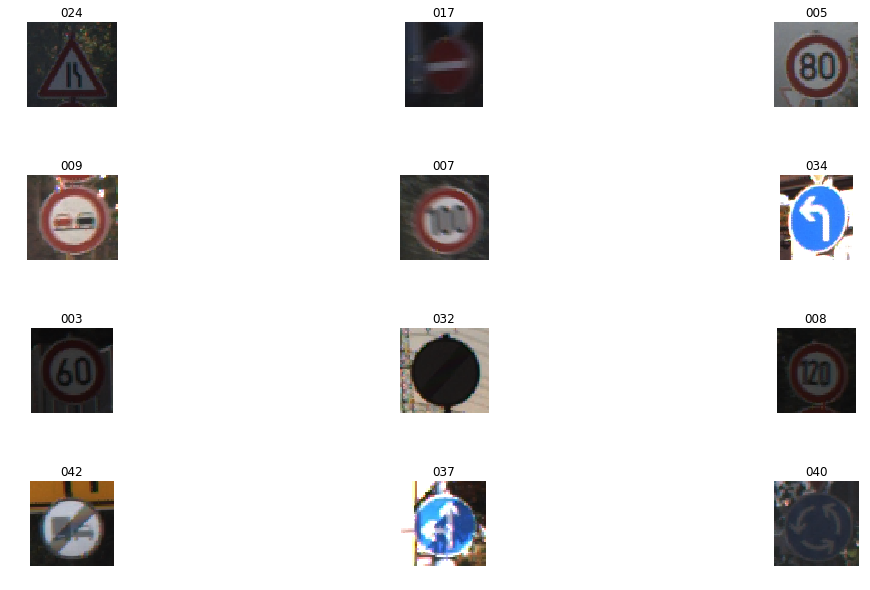

In [90]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#code to plot the images    
fig, ax = plt.subplots(4,3, figsize =(20,10))
fig.subplots_adjust(hspace = .8, wspace = .001)
ax = ax.ravel()
for i in range(12):
    a = '00'+path[i]+'_00000_00022.png'
    path_ = os.path.join('validation_set',path[i],a)
    img=mpimg.imread(path_)
    ax[i].axis('off')
    ax[i].imshow(img)
    ax[i].set_title(path[i])





## STEP 3: CONVERTING INPUT FORMAT TO  "lst format"

- The image classification algorithm can take two types of input formats. The first is a RecordIO format (content type: application/x-recordio) and the other is a lst format (content type: application/x-image). 
- From the documentation, it seems aws inbuilt algorithm seems to perform well on these two type of input formats.

In [ ]:
#to download im2rec.py file

download('https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py','im2rec.py')

In [ ]:
#this bash commad line to convert the data into .lst format

%%bash

python im2rec.py --list --recursive GERMAN-TRAFFIC train_set

In [3]:
#this section helps to read and print the .lst file

!head -n 3  ./GERMAN-TRAFFIC.lst > example.lst #prints 3 of the .lst files
f = open('GERMAN-TRAFFIC.lst','r')
f2 = open('example.lst','r')
lst_content, lst = f.read(), f2.read()

print(lst)
print(len(lst_content))   #total number of training images


174	2.000000	002/00002_00066_00023.png
2504	41.000000	41/00041_00006_00020.png
794	13.000000	013/00013_00018_00026.png

103290


In [ ]:
%%bash

python im2rec.py --list --recursive GERMAN-TRAFFIC-VALIDATION validation_set

In [4]:
!head -n 3 ./GERMAN-TRAFFIC-VALIDATION.lst > example-val.lst
f = open('example-val.lst','r')
lst_content = f.read()
print(lst_content)

3763	42.000000	042/00042_00000_00013.png
1521	17.000000	017/00017_00000_00021.png
599	6.000000	006/00006_00002_00029.png



## STEP 4: UPLOADING THE TRAINING AND VALIDATION SET TO THE S3 BUCKET

In [3]:
# Four channels: train, validation, train_lst, and validation_lst
s3train = 's3://{}/image-classification/train/'.format(bucket)
s3validation = 's3://{}/image-classification/validation/'.format(bucket)
s3train_lst = 's3://{}/image-classification/train_lst/'.format(bucket)
s3validation_lst = 's3://{}/image-classification/validation_lst/'.format(bucket)

# upload the image files to train and validation channels
!aws s3 cp train_set $s3train --recursive --quiet
!aws s3 cp validation_set $s3validation --recursive --quiet

# upload the lst files to train_lst and validation_lst channels
!aws s3 cp GERMAN-TRAFFIC.lst $s3train_lst --quiet
!aws s3 cp GERMAN-TRAFFIC-VALIDATION.lst $s3validation_lst --quiet

## STEP 5: CREATING A  IMAGE-CLASSIFIER 

In [4]:
#To retrieve the location of the container which is provided by Amazon for using image-classification.
#Same container can be used for the training and inference code. 

from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(sagemaker_session.boto_region_name, 'image-classification', repo_version="latest")
print (container)

825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest


## STEP 6: FINE TUNING THE IMAGE CLASSIFIER TO THE GTSRB DATASET

In [5]:
#output location where the trained model is stored
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

#train_instance_count: whether to run the algorithm in distributed settings
classifier = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.16xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker_session)

In [6]:
#change the values to tune the network

classifier.set_hyperparameters(num_layers=18,
                             use_pretrained_model=1,
                             image_shape = "3,32,32",
                             num_classes=43,
                             num_training_samples=103290,
                             mini_batch_size=128,
                             epochs=2,
                             learning_rate=0.01,
                             precision_dtype='float32')

## STEP 7: INPUT DATA SPECIFICATION:

In [7]:
#set the data type and data channels used for training

train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
train_data_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_lst': train_data_lst, 'validation_lst': validation_data_lst}

## STEP 8: TRAINING

In [8]:
#train the network using fit method

classifier.fit(inputs=data_channels, logs=True)

2019-11-03 18:05:05 Starting - Starting the training job...
2019-11-03 18:05:06 Starting - Launching requested ML instances......
2019-11-03 18:06:34 Starting - Preparing the instances for training............
2019-11-03 18:08:30 Downloading - Downloading input data...
2019-11-03 18:09:01 Training - Downloading the training image.....
2019-11-03 18:09:50 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[11/03/2019 18:09:54 INFO 140276273690432] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[11/03/2019 18:09:54 INFO 1402762736904

## STEP 9: DEPLOY MODEL FOR TESTING

In [9]:
#Deplying the model to perfrom inference like predicting the class given the input image

traffic_classifier = classifier.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

-------------------------------------------------------------------------------------------------!

## STEP 10: USING DEPLOYED MODEL FOR TESTING

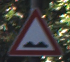

In [24]:
file_name = 'test.png'
from IPython.display import Image
Image(file_name)  

In [25]:

import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
    
#since we are using .lst format , content type is 'application/x-image'
traffic_classifier.content_type = 'application/x-image'

# the result will output the probabilities for all classes
result = json.loads(traffic_classifier.predict(payload)) 

#index of the class with maximum probability
index = np.argmax(result) 

print(index)

object_categories = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']

print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

22
Result: label - Bumpy road, probability - 0.998139500617981


## STEP 11: DELETE THE ENDPOINT

- Make sure to delete the endpoint after using, or else it will continue to run and we will be charged for the duration of the instance.

In [26]:
traffic_classifier.delete_endpoint()